In [2]:

import networkx as nx
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
import re
import sys
sys.path.insert(0, os.environ['PLOT_SETTINGS_DIR'])
import plot_settings
import seaborn as sns
def read_ising(path: str):
    with open(path) as infile:
        G = nx.Graph()
        edges = []
        offset = 0 if '.gset' in path else 1
        nodes, n_edges = map(int, infile.readline().strip().split())
        const = 0
        J = np.zeros((nodes, nodes))
        for line in infile:
            args = line.strip().split()
            u, v = map(int, args[:2])
            edges.append((u-offset, v-offset))
        # h /= J.abs().max()
        # J /= J.abs().max()
        G.add_nodes_from(range(nodes))
        G.add_edges_from(edges)
        return G
def row_elim(mat, blocks):
    remmat = mat
    for b in blocks:
        eye = np.eye(mat.shape[0])
        eye[b,:] = 0
        # print(eye.shape)
        remmat = eye @ remmat
        remmat[:, b] *= 2
        remmat = (remmat + remmat.T)/2
    
    return remmat

In [14]:
df

,job,burn_in,fixed-temp,schedule,scale0,samples,graph_class,graph,tpart,iter,...,flips,cut,ene,anneal,u,m,syncs,surprise_flips,gradient_difference_norm,EvalExt
0,1,5000,True,quad,1.0,30000,partitioning_strengths,fc_1_inner_1_outer.gset,2.000000e-09,0,...,2731.0,10757.0,-21663.0,0.000001,-21.5416,-0.034914,499.0,723.0,11482.8,1.00
1,2,5000,True,quad,1.0,30000,partitioning_strengths,fc_1_inner_1_outer.gset,2.000000e-09,1,...,3820.0,11234.0,-22617.0,0.000001,-22.1133,-0.056219,499.0,831.0,19236.6,1.00
2,3,5000,True,quad,1.0,30000,partitioning_strengths,fc_1_inner_1_outer.gset,2.000000e-09,2,...,2829.0,10900.0,-21949.0,0.000001,-21.8192,0.015007,499.0,702.0,12502.7,1.00
3,4,5000,True,quad,1.0,30000,partitioning_strengths,fc_1_inner_1_outer.gset,2.000000e-09,3,...,2643.0,10902.0,-21953.0,0.000001,-21.7619,0.046525,499.0,693.0,12849.6,1.00
4,5,5000,True,quad,1.0,30000,partitioning_strengths,fc_1_inner_1_outer.gset,2.000000e-09,4,...,2572.0,10669.0,-21487.0,0.000001,-21.3759,-0.060634,499.0,748.0,11520.9,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3996,5000,True,quad,1.0,30000,partitioning_strengths,fc_1_inner_1.75_outer.gset,6.000000e-09,35,...,58320.0,11297.5,-24007.5,0.000001,-21.6658,-0.016991,166.0,23892.0,220389.0,1.75
3996,3997,5000,True,quad,1.0,30000,partitioning_strengths,fc_1_inner_1.75_outer.gset,6.000000e-09,36,...,46834.0,12375.5,-26163.5,0.000001,-25.4944,0.024438,166.0,18445.0,185784.0,1.75
3997,3998,5000,True,quad,1.0,30000,partitioning_strengths,fc_1_inner_1.75_outer.gset,6.000000e-09,37,...,49853.0,11893.0,-25198.5,0.000001,-24.7501,-0.014256,166.0,19886.0,187441.0,1.75
3998,3999,5000,True,quad,1.0,30000,partitioning_strengths,fc_1_inner_1.75_outer.gset,6.000000e-09,38,...,56336.0,10295.5,-22003.5,0.000001,-22.0384,0.017955,166.0,22919.0,215680.0,1.75


<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_46888/2843370393.py:2: SyntaxWarning: invalid escape sequence '\.'
  df['EvalExt'] = df['graph'].str.extract('([\.\d]+)_outer').astype(float)


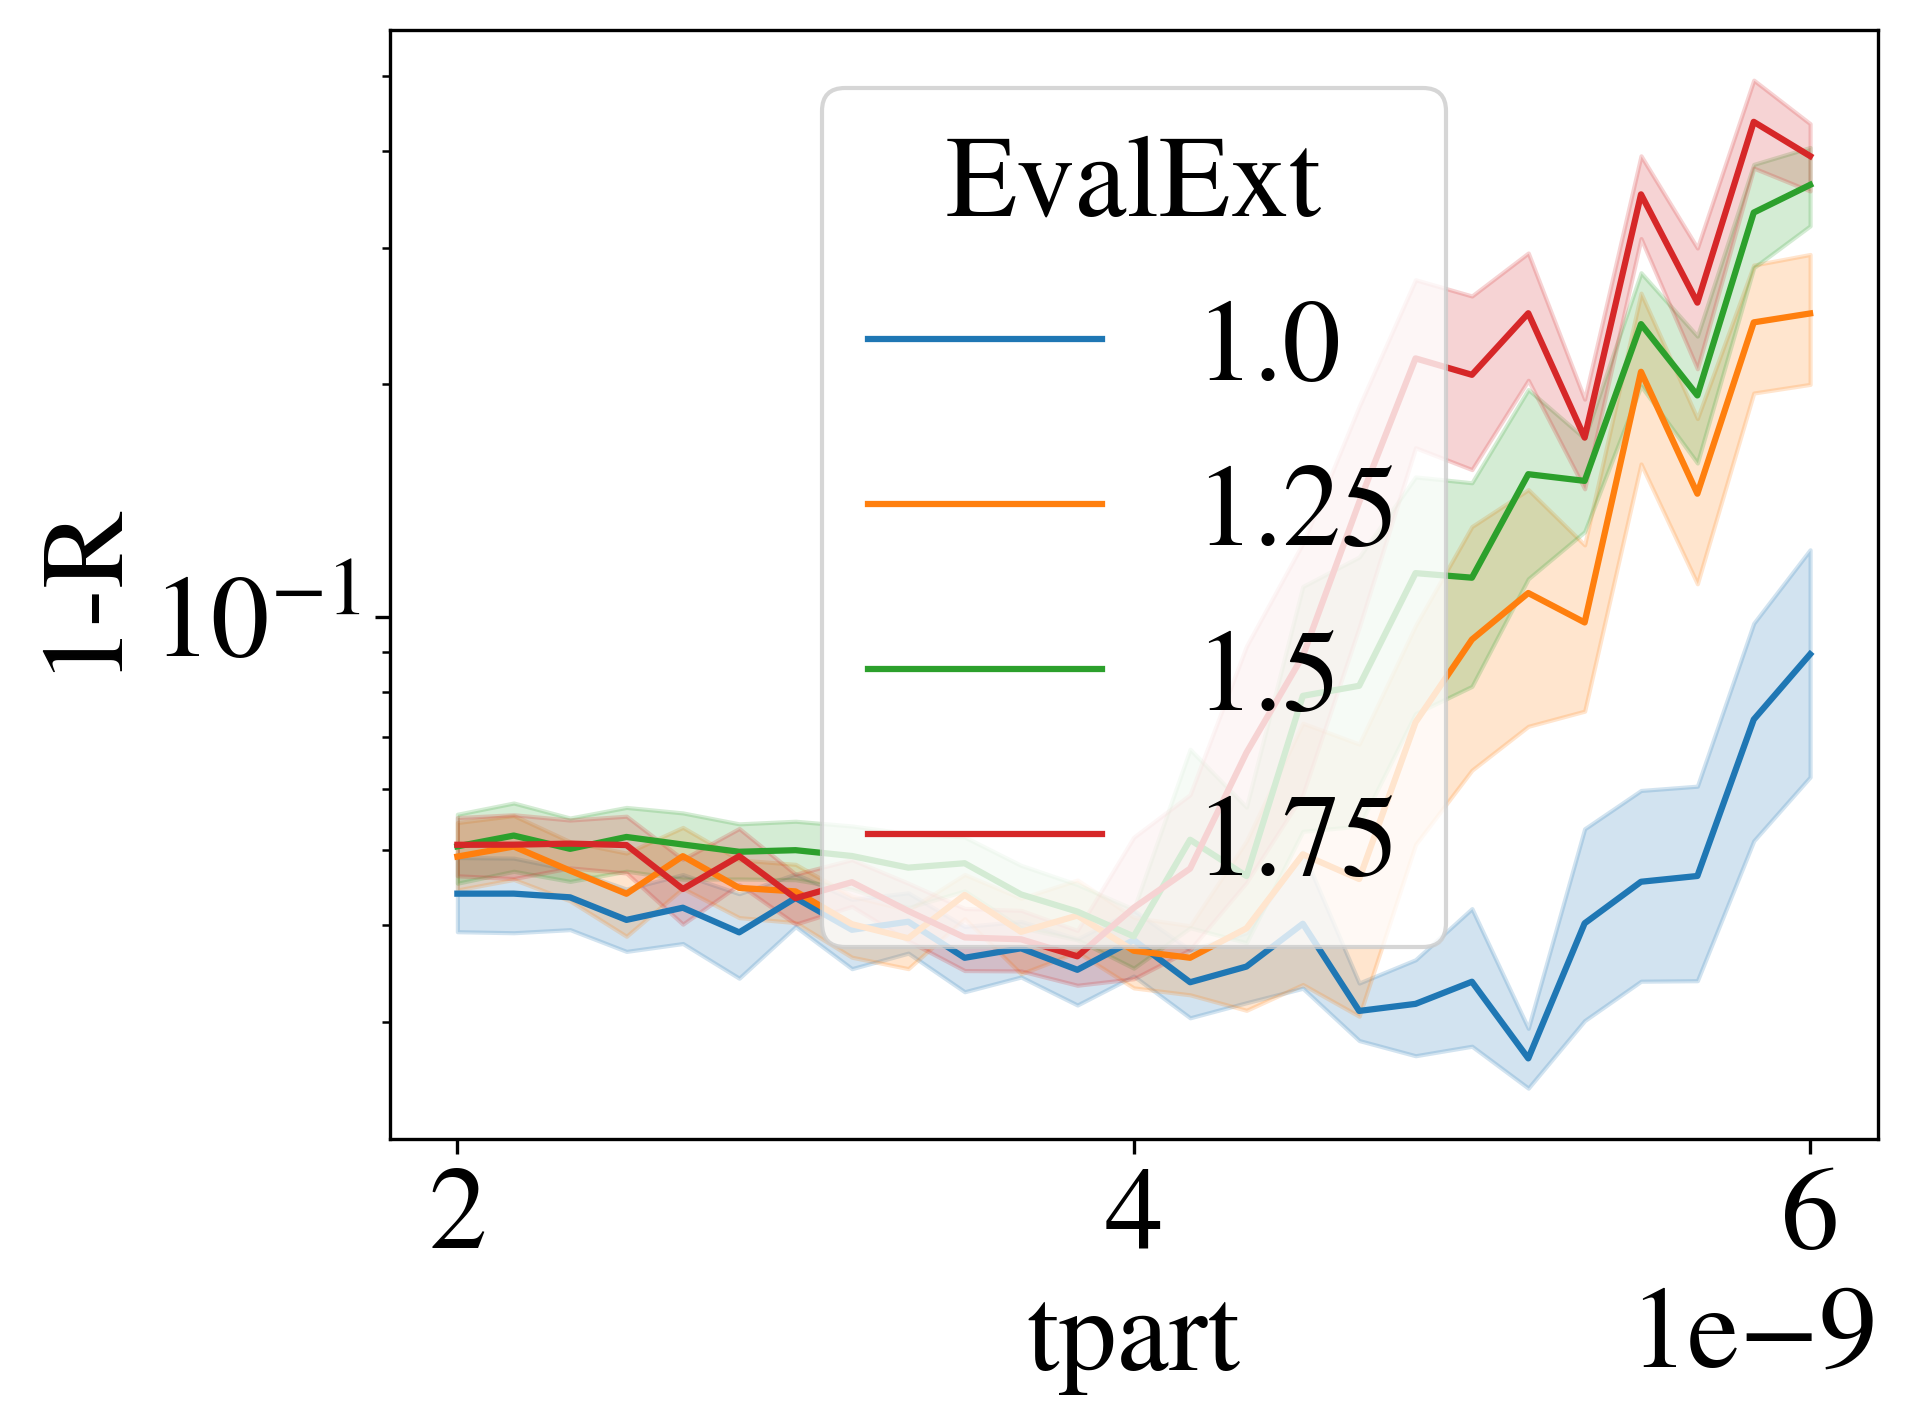

In [19]:
df = pd.read_csv(f'../data/sim002_partitioning_strengths.csv').query('scale0 == 2.0')
df['EvalExt'] = df['graph'].str.extract('([\.\d]+)_outer').astype(float)
max_df = df.groupby('graph').min().reset_index().rename(columns={'ene': 'BKS'})[['graph', 'BKS']]
df = df.merge(max_df, on='graph')
df['R'] = df['ene'] / df['BKS']
df['1-R'] = 1-df['R']

ax=sns.lineplot(data=df, x='tpart', y = '1-R', hue='EvalExt', palette='tab10')
ax.set_yscale('log')